content:      22:00 - 23:30
github order: 00:00 - 00:30
graphics:     00:30 - 01:00
GOOD NIGHT!

<p float="center">
 <img src="Resources/EverCompliantLOGO.png" width="300" hspace="50"/> 
 <img src="Resources/BarIlanLOGO.jpg" width="240" hspace="50"/> 
</p>
fix this!

# Classification Feedback Loop PoC - Project Paper

As a final assignment of the course 'Applied Data Science with Python' by dr. Omri Allouche, for graduate students at the EE faculty of Bar-Ilan University, we collaborated with the cyber risk intelligence company EverCompliant.\
Our team was: **Ofir Ben David**, **Daniel Einy**, **Nir Hen** and **Daniel halili**, all are M.Sc. students.\
As for EverCompliant side, we've worked with: **Inbal Budowski-Tal** *Director of AI* and **Inbal Gilaed** *Director of Product & BI* \
This notebook summarizes the work we've done, and presents the results and insights gained.

### company scenario and project goals

As part of EverCompliant activity to uncover hidden, suspicious and fraudulent e-commerce, one of the key tasks is to classify websites to their Line of Business (LoB classification).
Amongst other methods, the company has a model that classify websites using their textual content.
From time to time, this model requires a re-train, in order to improve performance or to be updated with the changing environment. For this training, new labeled data is needed.
Unfortunately, labeling the data is an expensive process in terms of time and money. Also, retraining the models on additional labeled data does not always produce improvement.
For this project, the company specified two two goals: 

* The major goal: Find a way to make labeling process more efficient by focusing on the most relevant and important samples.
* Optional: Formulate method to recgonize 'model sturation' a stage where more data won't improve the model. We haven't  reached this part.

As we saw in class, there is a relatively-new field termed 'Active Learn', that try to deal with this problems, and in the project we have dived into it and tried to find the best-fitting methods.
First, a [project plan](https://docs.google.com/viewer?url=https://github.com/DanielEiny/Classification-Feedback-Loop-PoC/raw/master/Resources/ProjectPlan.pdf) was written.\
Pale lines means work that we haven't done. As for timing, the EDA part was much longer then estimated, but we have done it in parallel with the learning parts. 

### So what is Active Learn? short review
As stated above, in active learn we try to find, before labeling, the most effective samples, in terms of the excpected improvement of the classifier.\
Basically, we can divide the approaches to two main categories:
* Classifeir prediction based - In this approach we use the previous classifier (the one we want to improve) and apply it over the pool of possible sample. Analyzing the predictions of each sample, we can collect the most 'unscertain' sample, assuming that training on this edge cases will improve our classifier.
* Feature based - using only the samples' feature space, we try to find the most interesting samples: the most representive, the most extreme etc.
Another aspect of active learn is how you orgenize the possible samples:
* Stream-based - Samples arriving continousely, and for each one you decide whether to send for labeling or not.
* Pool-based - Samples are coming in large pool from which you select certain amount.
* synth-based - There are no 'real' samples, instead you produce interesting samples using GANs etc.

For a good starting point, there is an [excellent survey](http://burrsettles.com/pub/settles.activelearning.pdf) (but of 2010…)\
Also there are open-source packeges. here we have used [modAL](https://github.com/modAL-python/modAL), useful framework with great documentation.

Later we will go into more details about what actually we have used.

### Here comes the Data

The company’s dataset contains around 3 million websites labelled by their LoB. The company has an internal list of ~400 LoB categories, e.g. hairdressing and beauty treatment, advertising agencies, restaurants and cafes. For this project we will use a small subset from the company’s dataset, the subset we will use is the finance Lob dataset. Every sample in the dataset is one website. Below is the description of the columns of the data subset we will work on:

-	*Domain* – the website address
-	*Language* – the language of the content in the website
-	*Content* – the raw text of the entire website
-	*Label* – the “Line of Business” (Lob) of the website


### Issues for EDA

Even before we did the research on the data itself, we researched various methods for creating features vectors for textual data as well as different methods for performing "active learn".<br><br>
An explanation of the different approaches to "active learn" applications, that we were exposed to during the study, can be found in the Notebook of the "Active Learn Framework".<br><br>
In this notebook, we will present the EDA and the pre-process we performed to create feature vectors for each labeled site in the dataset we received from the company<br><br>
During the research for creating numerical featur vectors for the textual data we received, we examined several processing methods. The most popular approach we have encountered is using word2vec (for its various types). At the beginning of the project, our group's initial decision was to use this technique and so during our EDA our main focus will be on the words of the various texts in the data set samples, so that we can have a good intuition of the nature of the initial decision we made.<br><br>
Another issue that has come to mind during this study is how to match 1 feature vector to each site:
Using word2vec on each site content will match any word to numeric feature vector. In order to create a feature vector for the entire site and not to every word in the site, we chose to use the TF-IDF algorithm to which we were also exposed during the study. Multiplying the TF-IDF weights in the entire site word vectors will yield a single vector for the entire site. <br><br>
The EDA and our pre-process begins with cleaning while searching for statistical relationships around the content of each site (not the content itself). Then, search for statistical relationships in the content of the sites themselves using word tokenizing, and finally perform the embeddings on each site content using "word2vec" (*Glove* in our case) and TF-IDF



### Imports

In [2]:
# imports
import math
import os
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data read

In [3]:
# NOTE: replace with your own data folder path
DATA_FOLDER = r'C:\Users\Ofir\Downloads'

In [4]:
# WARNING: this will take up to 3.0GB of your RAM -> might get your computer stuck

# read content df
content_df = pd.read_csv(os.path.join(DATA_FOLDER,'finance_en_content_all.csv'))
# read labels df
labels_df = pd.read_csv(os.path.join(DATA_FOLDER,'finance_en_labels_all.csv'))
# read categories df - match between label (number) to category (name)
categories_df = pd.read_csv(os.path.join(DATA_FOLDER,'categories.txt'),names=['label','category'])
categories_df['label'] = categories_df['label'].apply(lambda num_str_dirty: int(num_str_dirty.replace("'", "")))
categories_df['category'] = categories_df['category'].apply(lambda str_dirty: str_dirty.replace("'", ""))

# unit to 1 df:
content_labels_df = pd.merge(content_df,labels_df,on='domain')
content_labels_categories_df = pd.merge(content_labels_df,categories_df,on='label')

delete the non unit dataframes and create a dictionary of {label:category} for later use:

In [5]:
# delete the unnecessary dataframes
del content_df
del labels_df

# create a dictionary that match between label(key) to category (value)
categories = pd.read_csv(os.path.join(DATA_FOLDER,'categories.txt'), quotechar='\'', names=['label','category'])
categories = dict(zip(categories.label, categories.category))


### EDA (and preprocess on the go)

In [6]:
content_labels_categories_df.head()

,domain,content,language,label,category
0,99payday.com,California Check Cashing Stores – Community Ch...,en,17,Cashing Checks
1,a1cashadvance.com,A-1 Cash Advance | Helping our customers durin...,en,17,Cashing Checks
2,aandpcheckcashing.com,A & P Check Cashing | Cashing | Omaha NE HOME ...,en,17,Cashing Checks
3,advancepayusa.com,"Advance Pay USA | Payday Loans, Installment Lo...",en,17,Cashing Checks
4,afjewellers.co.uk,A.F. Discount Jewellery in London for jeweller...,en,17,Cashing Checks


print the size of the unit data frame: 

In [7]:
print(len(content_labels_categories_df.columns),len(content_labels_categories_df.index))

5 17201


check the labels distribuition:

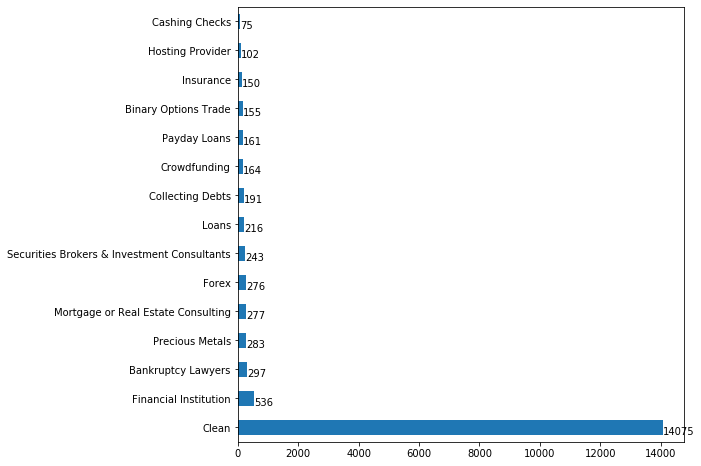

In [8]:
plt.figure(figsize=(8, 8)) 
ax = content_labels_categories_df.category.value_counts().plot(kind='barh')

for p in ax.patches:
    w = p.get_bbox().bounds[2]
    h = p.get_bbox().bounds[1]
    ax.annotate(int(w), xy = (w, h))

We can see that the data we received is *unbalanced*.
<br> About 80% of the examples belong to the "clean" category (it's the "non-financial site" label).
<br> More than that, in some of the classes we have a very small number of samples
<br> The imbalance expresses the "real" state of the internet (most of the sites are not financial).
<br> To deal with the imbalance, different methods suggasted: oversampling, downsampling, using the SMOTE algorithm and <br> more..
<br>
<br>
After consulting with the company members and together with the desire to get to the *active learn* stage quickly (since this is the main point of the project) we decided to get more data so that the imbalance will be kept but the bias will be smaller. 
The 'new' data was actually labeled using the current model of the company, but for our purposes it was fine.
<br> Next, in the performance evaluation stage of the selected classifier, we will also measure the performance in relation to the imbalance in the data
<br>
<br>
read the new data we got, match it to the content_labels_categories_df template and concat it to the old data:


In [9]:
new_content_df = pd.read_csv(os.path.join(DATA_FOLDER,'finance_sites_from_classifier.csv'))
new_content_df.columns = ['domain', 'label','content']
new_content_labels_categories_df = pd.merge(new_content_df,categories_df,on='label')

In [10]:
new_content_labels_categories_df.head()

,domain,label,content,category
0,bates-creek.com,109,Bates Creek Research and Consulting LLC home b...,Securities Brokers & Investment Consultants
1,virginiab2bcfo.com,109,Home - Mid South B2B CFO® Our Services Possibl...,Securities Brokers & Investment Consultants
2,sterlingheightsfinancial.com,109,Sterling Heights Financial | 401k Rollovers | ...,Securities Brokers & Investment Consultants
3,markbartercfo.com,109,"Mark Barter | Louisville, Kentucky CFO | B2B C...",Securities Brokers & Investment Consultants
4,premier-consultingpartners.com,109,Premier Consulting Partners Business Personal ...,Securities Brokers & Investment Consultants


In [11]:
df = pd.concat([new_content_labels_categories_df, content_labels_categories_df], sort = True)
df['language'] = df.language.fillna('en')
df = df.reset_index(drop=True)
df = df[['domain', 'content', 'language', 'label', 'category']]
df.head()

,domain,content,language,label,category
0,bates-creek.com,Bates Creek Research and Consulting LLC home b...,en,109,Securities Brokers & Investment Consultants
1,virginiab2bcfo.com,Home - Mid South B2B CFO® Our Services Possibl...,en,109,Securities Brokers & Investment Consultants
2,sterlingheightsfinancial.com,Sterling Heights Financial | 401k Rollovers | ...,en,109,Securities Brokers & Investment Consultants
3,markbartercfo.com,"Mark Barter | Louisville, Kentucky CFO | B2B C...",en,109,Securities Brokers & Investment Consultants
4,premier-consultingpartners.com,Premier Consulting Partners Business Personal ...,en,109,Securities Brokers & Investment Consultants


delete the old saperate data frames, and check the label distribution again:

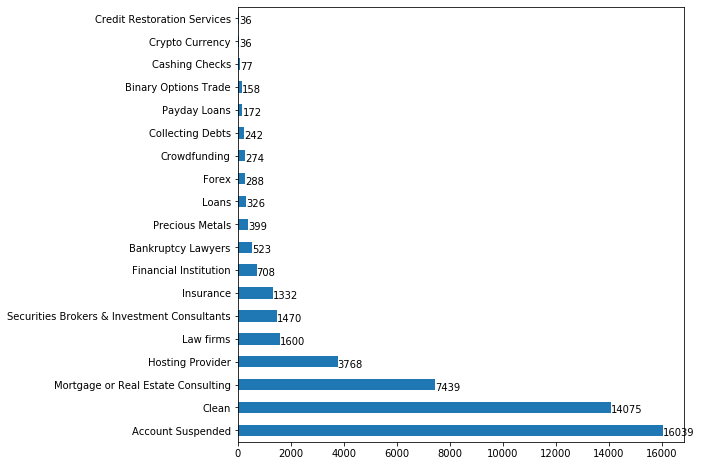

In [12]:
del content_labels_categories_df
del new_content_labels_categories_df
del new_content_df

plt.figure(figsize=(8, 8)) 
ax = df.category.value_counts().plot(kind='barh')

for p in ax.patches:
    w = p.get_bbox().bounds[2]
    h = p.get_bbox().bounds[1]
    ax.annotate(int(w), xy = (w, h))

delete the "Account suspended" category (Accidentally brought by the company members), print the actual relevant size of the df and plot the distribution again

In [13]:
df = df[df.category != 'Account Suspended']
print(len(df.columns),len(df.index))

5 32923


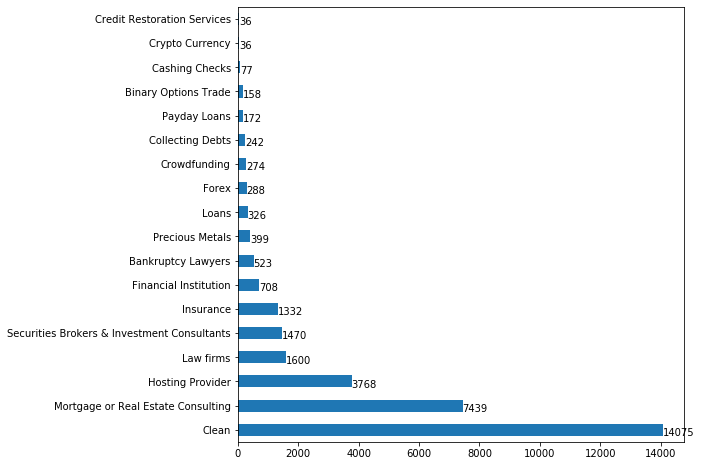

In [14]:
plt.figure(figsize=(8, 8)) 
ax = df.category.value_counts().plot(kind='barh')

for p in ax.patches:
    w = p.get_bbox().bounds[2]
    h = p.get_bbox().bounds[1]
    ax.annotate(int(w), xy = (w, h))

We can see that the "clean" category is still the major category, but now only 50% from the samples are from the "clean" category.

checking the missing values in the data: 

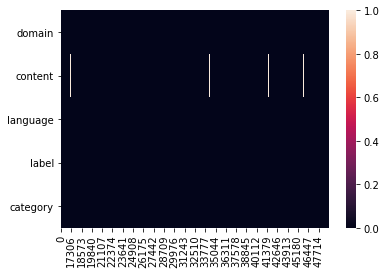

In [15]:
sns.heatmap(df.isnull().T.astype(int))

slightly hard to see, there are only missing values in the content column. 
<br>
Let's check the amount of the missing values: 


In [16]:
df.isnull().sum()

domain        0
content     807
language      0
label         0
category      0
dtype: int64

There are missing values in about 800 samples, let's check the label distribution for the missing values:

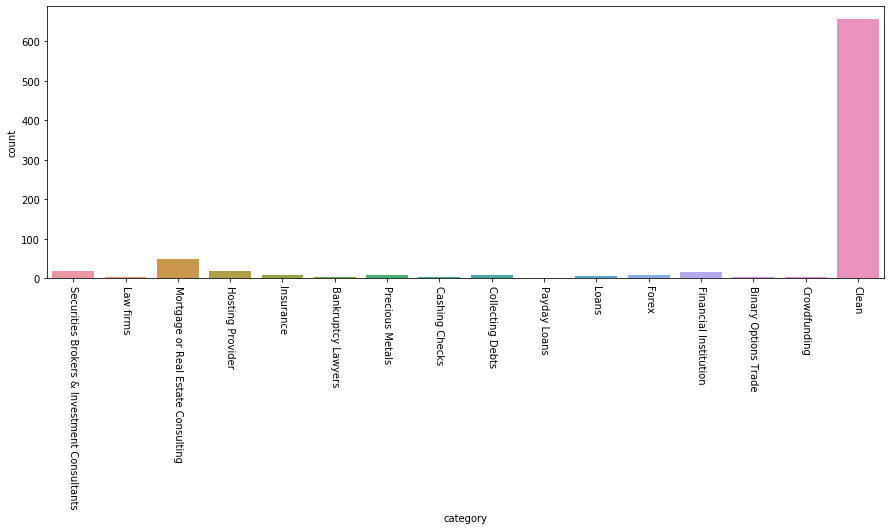

In [17]:
plt.figure(figsize=(15,5)) # this creates a figure 10 inch wide, 5 inch high
sns.countplot(df[df['content'].isna()]['category'])
plt.xticks(rotation=-90)
plt.show()

Most of the missing values are in the 'clean' category, it's hard to say that this is a property that can be used. Also, the features we want to test are based on the content of each site (tokenizing + embeddings). So at this stage we decided to filter out the contentless sites:

In [18]:
df.dropna(axis=0, inplace=True)
print(len(df.columns),len(df.index))

5 32116


let's check the language distribution:

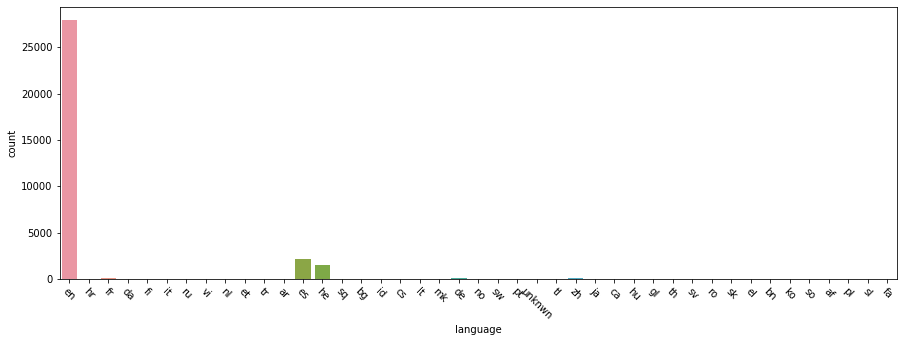

In [19]:
plt.figure(figsize=(15,5)) # this creates a figure 10 inch wide, 5 inch high
sns.countplot(df['language'])
plt.xticks(rotation=-45)
plt.show()

Most of the sites contain English language content. We decided to filter the other languages based on the desire to use 'Embeddings' packages that work for English content only.

In [20]:
df = df[df['language'] == 'en']
print(len(df.columns),len(df.index))

5 27937


After the first cleaning, let's begin to look for statistical relationships in the data and find potential features.
<br>
<br>
let's check the label distribution by the content length (number of words) of each site:

In [21]:
# NOTE: df['content_len'] could be replaced with cleaned version of content,
# Meaning after nltk.stop_words, etc.
df['content_len'] = df['content'].apply(len)

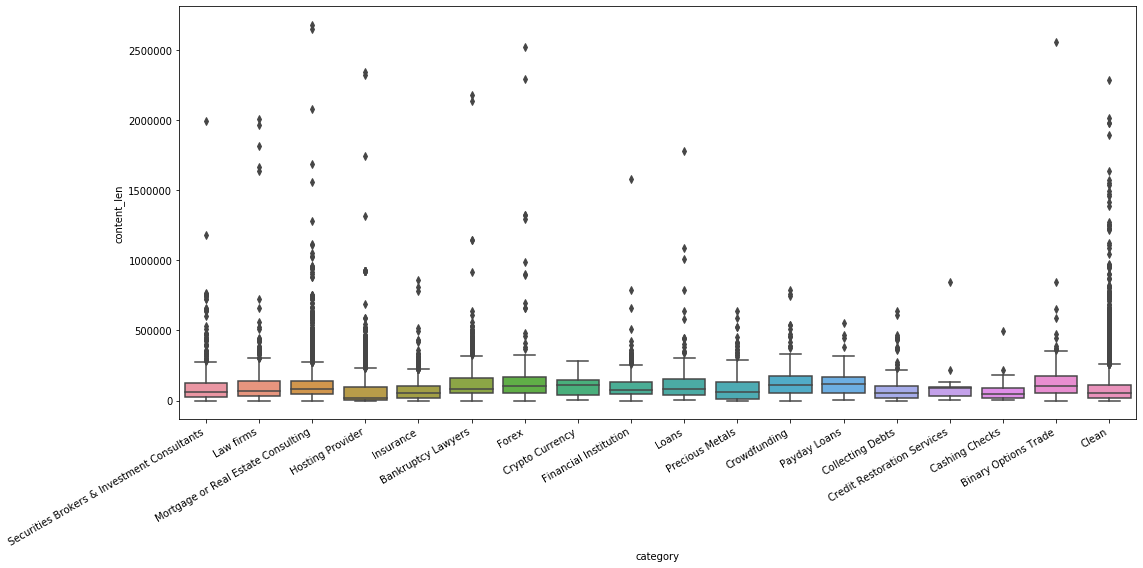

In [22]:
# boxplot showing the content length distribution per category
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x='category', y='content_len', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
plt.show()

We can see that the length of most sites does not exceed half a million words, most of the outliers does not exceed 750K words.
let's clean the far outliers:

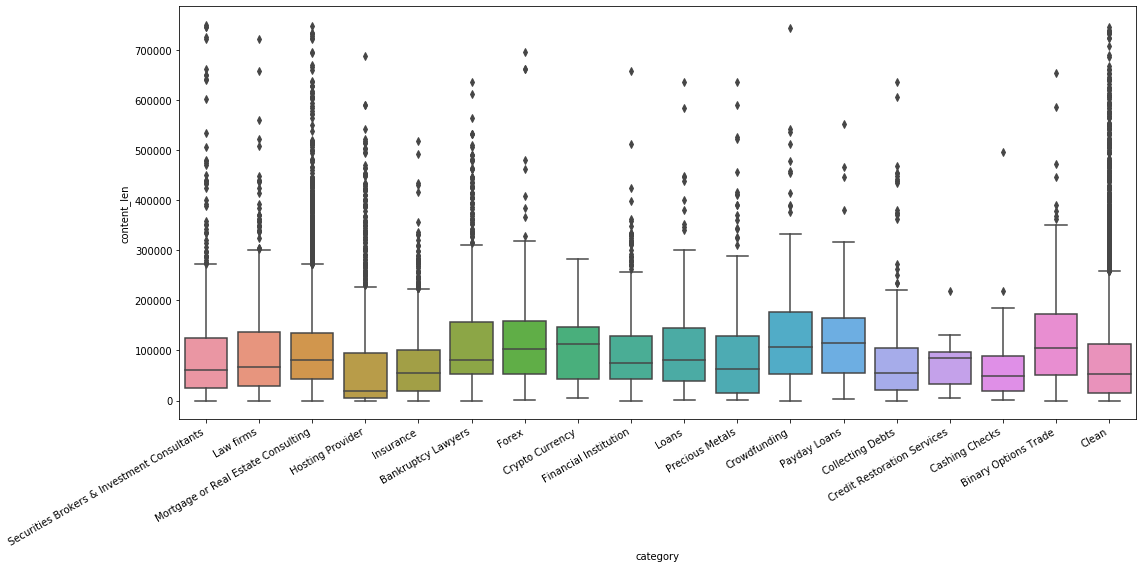

In [23]:
plt.figure(figsize=(16, 8))
df = df[df['content_len'] <= 750000]
ax = sns.boxplot(x='category', y='content_len', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
plt.show()

It can be seen that in most categories the length of the content of the sites is in the same range.
<br>
although there are categories where the length is relatively low compared to the rest, e.g "Hosting Provider"
<br>
interesting!

now, let's try to check the label distribution by the domain postfix of each site:

In [24]:
# domain postfix extraction
def get_domain_postfix(domain_str):
    return domain_str.split('.')[-1]
df['domain_postfix'] = df['domain'].apply(get_domain_postfix)

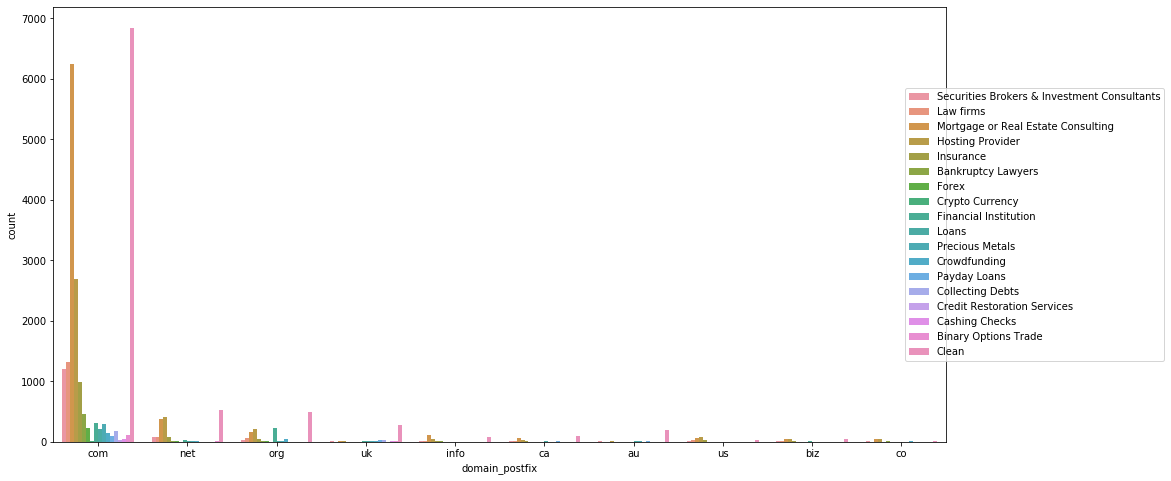

In [25]:
# countplot of the categories distribution by domain postfix, showing top 10 popular postfix
plt.figure(figsize=(16, 8))
ax = sns.countplot(x="domain_postfix", hue="category", data=df,
                   order=df.domain_postfix.value_counts().iloc[:10].index)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

We can see that most sites have the .com domain postfix. The 'clean' category has a majority in each postfix type and this is understandable due to the imbalance of the data. It can be seen that for the .org postfix there are more samples from the 'financial institution' category relative to the other categories - maybe another interesting insight..

<br>
After researching a bit around the content of the sites (language, domain extension and content length), we will try to examine statistical relationships in the content itself. As we mentioned above, our desire in the first place is to use word2vec methods, so we want to see if we can use the content itself to perform the features for the classification.
<br>
Intuitively, if we focus on the content of the financial websites, and we can show on one hand a difference between the content of the different categories, and on the other hand a similarity in the content of the different categories - we can say that the choice of using those methods is a good choice.
<br>
i.e: Similarity between the financial sites from all the financial categories can give a good separation between a financial and non-financial sites. difference in the financial sites between the variouse financial categories can give good separation between the financial sites themselves
<br><br>
let's find the most common words of the sites, <br>
for the EDA notebook we will show the graphs for 3 categories only, due to memory issues and graphic visibility.
in the next notebook we will load all the processed data we have prepared on a powerful server that we have at the university.
<br>we will use the nltk package to the word tokenizing process:

_Tokenizing_

In [30]:
import nltk
short_df = df.loc[df['category'].isin(['Forex','Financial Institution', 'Loans'])]
short_df['words'] = short_df.content.apply(nltk.word_tokenize)
short_df.words.head()

C:\Users\Ofir\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


31102    [Forex, Brokers, |, FX, Trading, Software, |, ...
31103    [ECN, Forex, Broker, |, ECN, Forex, Trading, |...
31104    [RobCoin, This, website, uses, cookies, to, en...
31105    [Westmark, Trading, This, website, uses, cooki...
31106    [TradingPub, |, FREE, Futures, and, Options, T...
Name: words, dtype: object

let's filter the non-alphabetic words, the stop words and the extensions(lemmatize): 

In [31]:
# filter the non alphabetic words and the "1 letter" words
short_df['words'] = short_df.words.apply(lambda tokens: [t.lower() for t in tokens if t.isalpha() and len(t) > 1])

# using the stop words vocabulary of the nltk package
stop_words = set(nltk.corpus.stopwords.words('english')) 
short_df['words'] = short_df.words.apply(lambda tokens: [t for t in tokens if t not in stop_words])


C:\Users\Ofir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ofir\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
# lemmatizing
from nltk.stem import WordNetLemmatizer
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
short_df['words'] = short_df.words.apply(lambda words: [lemmatizer.lemmatize(w) for w in words])


short_df.words.head()

C:\Users\Ofir\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


31102    [forex, broker, fx, trading, software, axitrad...
31103    [ecn, forex, broker, ecn, forex, trading, fore...
31104    [robcoin, website, us, cooky, ensure, get, bes...
31105    [westmark, trading, website, us, cooky, ensure...
31106    [tradingpub, free, future, option, trading, ed...
Name: words, dtype: object

_Vectorizing using tokens counts_

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# walkaround to enable passing tokens to CountVectorizer
def dummy(doc):  
    return doc

# for each site, create a vector of the words' indexes and the number of their occurence  
cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
cv.fit(short_df.words)
cv.get_feature_names()
vectorized_content = cv.transform(short_df.words)

vectorized_content

<1235x97327 sparse matrix of type '<class 'numpy.int64'>'
	with 1475920 stored elements in Compressed Sparse Row format>

after the cleaning and the vectorizing, let's find the 10 most frequent words in the whole dataset

In [35]:
#can be replace to other numbers..
number_of_words = 10

short_df.reset_index(inplace=True)
short_df_indices = short_df.index.tolist()
apperance_words_frequency_array = vectorized_content[short_df_indices].sum(axis=0)

words_freq = [(word, apperance_words_frequency_array[0, idx],idx) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

print(words_freq[:number_of_words])

[('loan', 248049, 43379), ('credit', 149384, 16723), ('account', 129909, 512), ('service', 117535, 67337), ('u', 103449, 76916), ('rate', 85840, 61197), ('information', 79661, 36222), ('card', 78319, 11276), ('banking', 75337, 6453), ('business', 73823, 10334)]


It can be seen that for the financial categories we have chosen, the 10 most common words contain mostly "financial" words. Although, there are also words with no financial character like 'us','rate','information'.<br>
*This is a good sign*, It seems that the assumptions we started with were in the right direction!
<br><br> let's check the 10 most frequent words distribution by category:

In [37]:
most_common_index = []
most_common_words= []
most_common_amount = []
for i in range(number_of_words):
    most_common_words.append(words_freq[:number_of_words][i][0])
    most_common_amount.append(words_freq[:number_of_words][i][1]) 
    most_common_index.append(words_freq[:number_of_words][i][2])


categories = short_df.category.unique().tolist()
amount_by_category = []
temp = pd.DataFrame()
for category in categories:
    short_df_indices_by_category = short_df.index[short_df.category == category].tolist()  
    apperance_words_frequency_array_by_category = vectorized_content[short_df_indices_by_category].sum(axis=0)
    apperance_words_frequency_array_by_category = [i/len(short_df_indices_by_category) for i in apperance_words_frequency_array_by_category]
    amount_by_category.append([apperance_words_frequency_array_by_category[0].tolist()[0][i] for i in most_common_index]) 
    temp = pd.concat([temp,pd.DataFrame(data={'word':most_common_words,'category': [category]*len(most_common_words), 'avg': amount_by_category[categories.index(category)]})])

temp.reset_index(inplace=True,drop=True)
temp.sort_values(by='avg', axis=0, ascending=False)

,word,category,avg
20,loan,Loans,364.533762
10,loan,Financial Institution,204.610350
11,credit,Financial Institution,170.729072
12,account,Financial Institution,145.633181
13,service,Financial Institution,121.628615
21,credit,Loans,115.591640
18,banking,Financial Institution,111.952816
17,card,Financial Institution,106.943683
15,rate,Financial Institution,97.235921
26,information,Loans,96.726688


Text(0.5, 1.0, 'Ten most common words in all data set - distrbution for 3 categories')

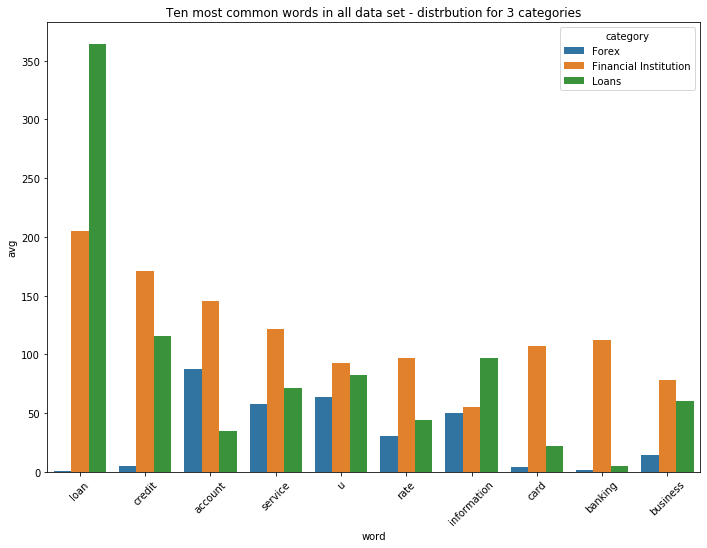

In [38]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x="word", y="avg", hue="category", data=temp)
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.title('Ten most common words in all data set - distrbution for 3 categories')

In line to the intuition we started with, we can see differences and similarities among the common words in the financial categories!<br>
To further strengthen this intuition, let's review the 10 common words for each category relative to their appearance in the other categories

In [43]:
number_of_words_by_category = 10
most_common_by_category =[]
most_common_by_category_word = []

for category in categories:
    subset_indices = short_df[short_df.category == category].index.tolist()
    apperance_words_frequency_array = vectorized_content[subset_indices].sum(axis=0)

    words_freq = [(word, apperance_words_frequency_array[0, idx]/len(subset_indices),idx) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    most_common_by_category.append([freq[2] for freq in words_freq[:number_of_words_by_category]])
    most_common_by_category_word.append([freq[0] for freq in words_freq[:number_of_words_by_category]])
    

In [44]:
print('Ten most common words for each label is:')
for inx,category in enumerate(categories):
    print("category - ",category,':')
    print(most_common_by_category_word[inx])
    print('----------------------------------------')

Ten most common words for each label is:
category -  Forex :
['forex', 'trading', 'market', 'account', 'trade', 'broker', 'trader', 'u', 'signal', 'service']
----------------------------------------
category -  Financial Institution :
['loan', 'credit', 'account', 'service', 'banking', 'card', 'rate', 'u', 'online', 'union']
----------------------------------------
category -  Loans :
['loan', 'credit', 'information', 'u', 'service', 'may', 'term', 'lender', 'personal', 'business']
----------------------------------------


now let's try to visualize it:

In [45]:
my_dict = {}
temp_df = list()
for i in range(len(categories)):
    for category in categories:
        index = short_df[short_df.category == category].index.tolist()
        temp_vec = vectorized_content[index,:]
        apperance_words_frequency_array = temp_vec[:,most_common_by_category[i]].sum(axis=0).tolist()[0]
        my_dict[category] = list(map(lambda x: x/len(index), apperance_words_frequency_array))
        
    my_dict['word']=most_common_by_category_word[i]
    temp_df.append(pd.DataFrame(my_dict))
    my_dict.clear()

In [46]:
df0 = pd.melt(temp_df[0],value_vars=categories,id_vars='word')
df1 = pd.melt(temp_df[1],value_vars=categories,id_vars='word')
df2 = pd.melt(temp_df[2],value_vars=categories,id_vars='word')

Text(0.5, 1.0, 'Ten most common words - Forex')

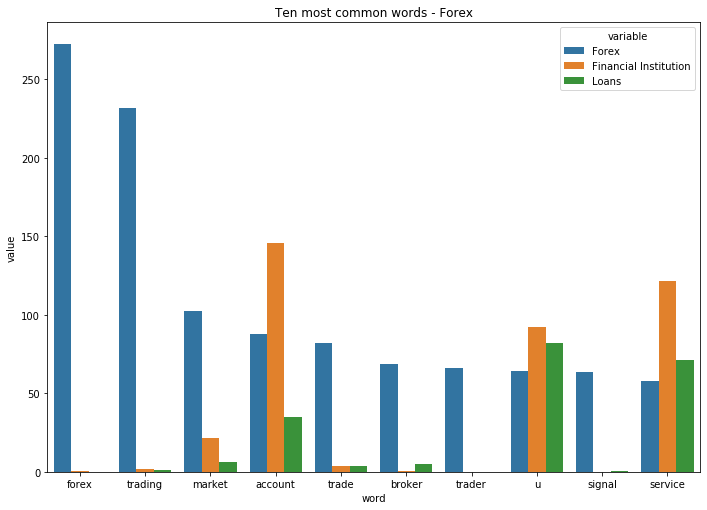

In [48]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x='word',hue='variable',y='value',data=df0)
plt.title('Ten most common words - {}'.format(categories[0]))

Text(0.5, 1.0, 'Ten most common words - Financial Institution')

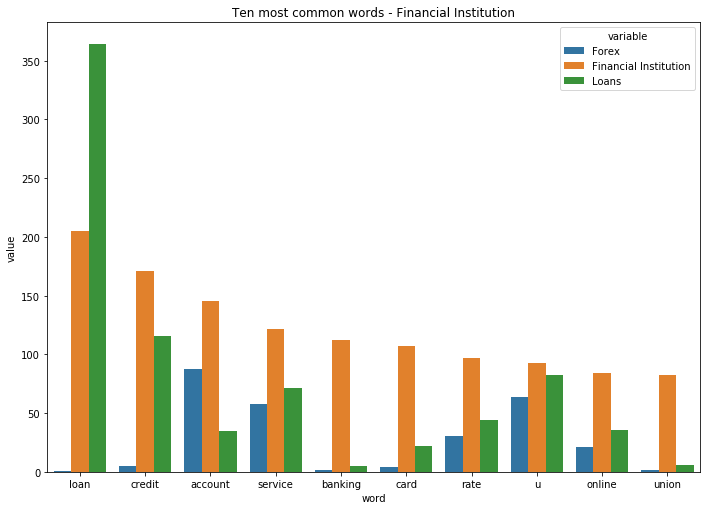

In [49]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x='word',hue='variable',y='value',data=df1)
plt.title('Ten most common words - {}'.format(categories[1]))

Text(0.5, 1.0, 'Ten most common words - Loans')

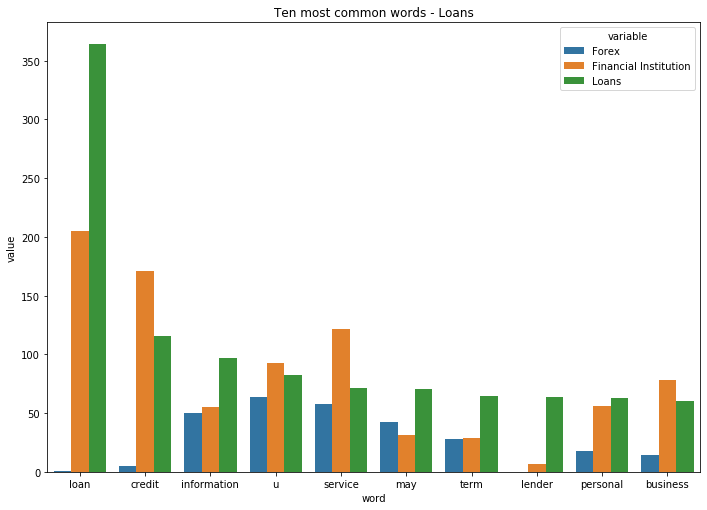

In [50]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x='word',hue='variable',y='value',data=df2)
plt.title('Ten most common words - {}'.format(categories[2]))

Great! the 10 most common words vary by category. Although, we can see some overlap in some of the common words in each category - according to the variance and similarities we were looking for!

In [59]:
number_of_words_by_category = 10
most_none_common_by_category =[]
most_none_common_by_category_word = []

for category in categories:
    subset_indices = short_df[short_df.category == category].index.tolist()
    apperance_words_frequency_array = vectorized_content[subset_indices].sum(axis=0)

    words_freq = [(word, apperance_words_frequency_array[0, idx]/len(subset_indices),idx) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=False)
    
    most_none_common_by_category.append([freq[2] for freq in words_freq[:number_of_words_by_category]])
    most_none_common_by_category_word.append([freq[0] for freq in words_freq[:number_of_words_by_category]])

In [61]:
print('Ten most uncommon words for each label is:')
for inx,category in enumerate(categories):
    print("category - ",category,':')
    print(most_none_common_by_category_word[inx])
    print('----------------------------------------')

Ten most uncommon words for each label is:
category -  Forex :
['overdraft', 'hablamos', 'newtek', 'ccu', 'ncua', 'nmls', 'thumbprint', 'estatements', 'deductibility', 'coloradocu']
----------------------------------------
category -  Financial Institution :
['axitrader', '中文繁體', 'nexgen', 'autochartist', 'psyquation', 'myfxbook', 'autotrade', 'metatrader', 'axi', 'binary']
----------------------------------------
category -  Loans :
['fx', 'axitrader', '中文', 'ภาษาไทย', '中文繁體', 'cfds', 'cfd', 'nexgen', 'autochartist', 'vps']
----------------------------------------


now let's try to visualize it:

In [62]:
my_dict = {}
temp_df = list()
for i in range(len(categories)):
    for category in categories:
        index = short_df[short_df.category == category].index.tolist()
        temp_vec = vectorized_content[index,:]
        apperance_words_frequency_array = temp_vec[:,most_none_common_by_category[i]].sum(axis=0).tolist()[0]
        my_dict[category] = list(map(lambda x: x/len(index), apperance_words_frequency_array))
        
    my_dict['word']=most_none_common_by_category_word[i]
    temp_df.append(pd.DataFrame(my_dict))
    my_dict.clear()

In [63]:
df0 = pd.melt(temp_df[0],value_vars=categories,id_vars='word')
df1 = pd.melt(temp_df[1],value_vars=categories,id_vars='word')
df2 = pd.melt(temp_df[2],value_vars=categories,id_vars='word')

Text(0.5, 1.0, 'Ten least common words - Forex')

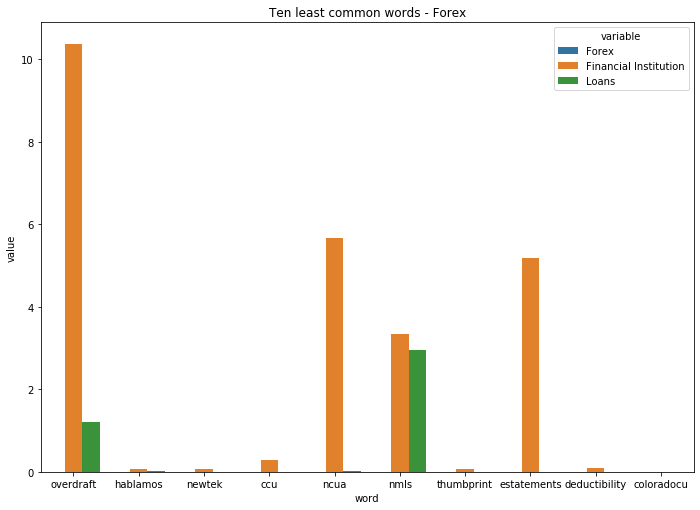

In [64]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x='word',hue='variable',y='value',data=df0)
plt.title('Ten least common words - {}'.format(categories[0]))

Text(0.5, 1.0, 'Ten least common words - Financial Institution')

C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 39636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 25991 missing from current f

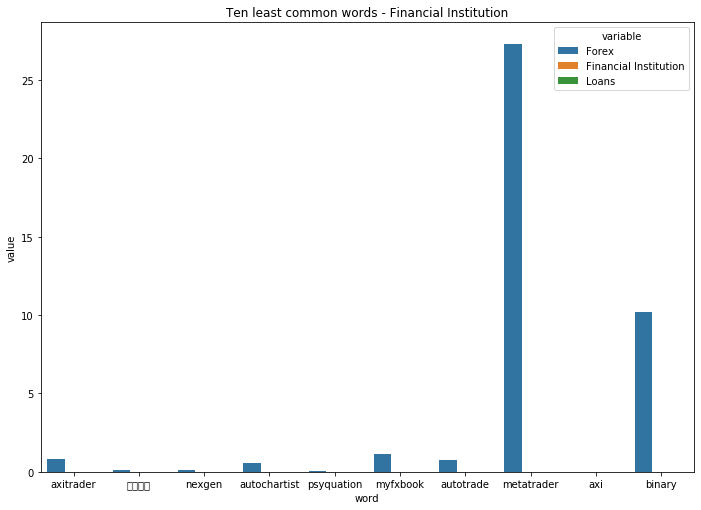

In [65]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x='word',hue='variable',y='value',data=df1)
plt.title('Ten least common words - {}'.format(categories[1]))

Text(0.5, 1.0, 'Ten least common words - Loans')

C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3625 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3607 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Ofir\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 3618 missing from current font.

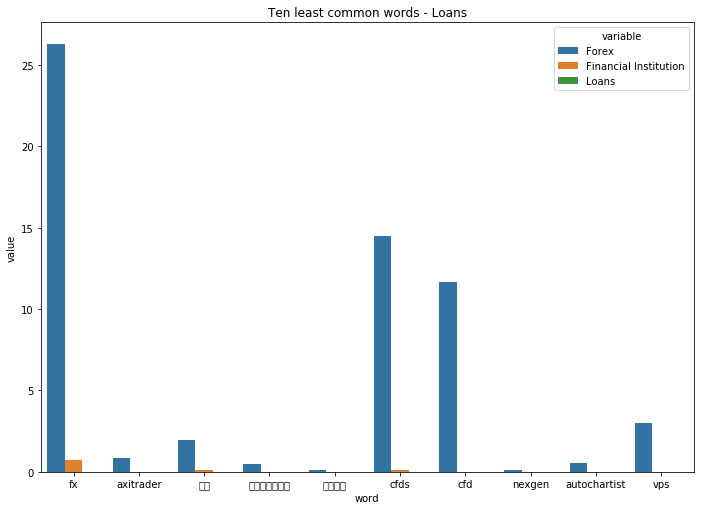

In [66]:
fig_size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_size)
sns.barplot(x='word',hue='variable',y='value',data=df2)
plt.title('Ten least common words - {}'.format(categories[2]))

Here too, there is variation among the least common words in each category. The TF-IDF algorithm gives higher weight to the less common words and the most common words. The variance we have shown reinforces the assumption that using word2vec with the TF-IDF will give a good separation between the categories in the feature space . <br><br>
Now, let's move on to creating the feature vectors


_Loading word2vec pretraind model_

In [68]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")

C:\Users\Ofir\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[==================================================] 100.0% 128.1/128.1MB downloaded


C:\Users\Ofir\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


_Removing word that are not in the model_

In [69]:
vocabulary = word_vectors.vocab
short_df['words'] = short_df.words.apply(lambda tokens: [t for t in tokens if t in vocabulary])
short_df.words.head()

C:\Users\Ofir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    [forex, broker, fx, trading, software, trader,...
1    [ecn, forex, broker, ecn, forex, trading, fore...
2    [website, us, ensure, get, best, experience, w...
3    [westmark, trading, website, us, ensure, get, ...
4    [free, future, option, trading, education, sho...
Name: words, dtype: object

Let's check how many labeled samples remained after all the filters we done:

In [79]:
len(short_df.words)

1235

after the filtering, vectorizing the content again:

In [74]:
cv = CountVectorizer(tokenizer=dummy,
                     preprocessor=dummy)
vectorized_content = cv.fit_transform(short_df.words)

_Computing tf-idf matrix_

In [75]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
tfidf_content = tfidf.fit_transform(vectorized_content)

_weighting token counts using tf-idf matrix_

In [76]:
vectorized_content = vectorized_content.multiply(tfidf_content)

_Converting tokens to feature vectors using word2vec embeddings_

In [77]:
w2v = cv.get_feature_names()
w2v = [word_vectors.get_vector(x) for x in w2v]
w2v = np.array(w2v)

Now, create a single feature vector for each site and check the size of the features matrix we got

In [78]:
vectorized_content = vectorized_content.dot(w2v)
vectorized_content.shape

(1235, 100)

As we planed, for each of the 1235 sites that exist in the dataset, we received a single 100-dimensional feature vector!

### EDA - Conclusions

*EDA Phase Summary:*

- Recognize the imbalance in our dataset and getting another data pull
- Cleaning missing values and outliers
- Choosing to work with text features using NLP techniques (word2vec & TF-IDF)
- Reserve potential features (content length, domain postfix and etc..) for Insufficient results

*Preprocess Phase Summary*:

- Using the "nltk" package for tokenizing, filter stop words and lemmatizing
- Using the "gensim" package to perform the word2vec embedding
- Using the TF-IDF implementation of "scikit learn" package to weigh every word in each site
- Creating a single features vector for each site by a dot multiplication between the last two


data preprocess

simple model

active learn framework [decisions]

measurements

results

what next

thanks